In [ ]:
# Preprocessing Data

import glob
import string
import re
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk.stem import PorterStemmer
import dill
import numpy as np
import math

## Removing Stopwords and Stemming the words
regex = re.compile('[^a-zA-Z ]')
stop_words = set(stopwords.words('english'))
pS = PorterStemmer()

#list of files containing positive reviews
posRevFile=glob.glob("pos/*.txt")

#list of files containing positive reviews
negRevFile=glob.glob("neg/*.txt")

#Y will contain class labels (1 for positive and 0 for negative)
Y=list()

#Reading from positive files and removing stopwords and stemming words
posList=list()
for i in posRevFile:
    Y.append(1)
    file=open(i,'r')
    wt=word_tokenize(regex.sub('',file.read().lower()))
    wt=[pS.stem(w) for w in wt if not w in stop_words] 
    posList.append(wt)
posSize=len(posList)

#Reading from negative files and removing stopwords and stemming words
negList=list()
for i in negRevFile:
    Y.append(0)
    file=open(i,'r')
    wt=word_tokenize(regex.sub('',file.read().lower()))
    wt=[pS.stem(w) for w in wt if not w in stop_words] 
    negList.append(wt)
negSize=len(negList)
fullDataSet=posList+negList


## Counting total number of unique words
totalVocabCounter=Counter()
for i in fullDataSet:
    totalVocabCounter.update(i)
vocabLen=len(totalVocabCounter)

## Remove words that have appeared less than 3 times
newTot=list()
for i in totalVocabCounter:
    if totalVocabCounter[i]>3:
        newTot.append(i)
totalVocabCounter=newTot
vocabLen=len(totalVocabCounter)


In [7]:
# Training and Testing
#fullDataSet is split into training and testing data by the following proportions
splitProportion = [0.1,0.3,0.5,0.7,0.8,0.9]
fdSize = len(fullDataSet)

#List containing average accuracy for a split over 5 runs
Accuracy = list()
for rs in splitProportion:
    trainSize = int(math.floor(rs*fdSize))
    testSize = fdSize-trainSize
    accuracyCount=0
    AccRun = list()
    
    #run 5 times for each split
    for run in range(5):
        #randomising the split
        randIdx = np.random.permutation(fdSize)
        trainIdx = np.ndarray.tolist(randIdx[0:trainSize])
        testIdx = randIdx[trainSize:]
        trainingLabels = []
        trainingSet = []
        for i in trainIdx:
            trainingLabels.append(Y[i])
            trainingSet.append(fullDataSet[i])
        testSet = []
        testLables = []
        for i in testIdx:
            testSet.append(fullDataSet[i])
            testLables.append(Y[i])
        ## Training Phase
        #Splitting training data to positive and negative reviews
        posTrnList=[]
        negTrnList=[]
        for i in range(trainSize):
            if trainingLabels[i] == 1 :
                posTrnList.append(trainingSet[i])
            else :
                negTrnList.append(trainingSet[i])
        posVocabCounter = Counter()
        negVocabCounter = Counter()
        for i in posTrnList:
            posVocabCounter.update(i)
        for i in negTrnList:
            negVocabCounter.update(i)
        #Counting total number of occurences of each word in the positive and negative reviews separately
        posDict = {}
        negDict = {}
        for i in totalVocabCounter:
            wordCount = 0
            if i in posVocabCounter:
                wordCount = posVocabCounter[i]
            # P(Y|X)=(# of occurences of word in +ve Class + 1)/(# of +ve class + vocabSize)
            posDict[i] = math.log((1+wordCount)/(posSize+vocabLen))
            wordCount = 0
            if i in negVocabCounter:
                wordCount = negVocabCounter[i]
            # P(Y|X)=(# of occurences of word in -ve Class + 1)/(# of -ve class + vocabSize)
            negDict[i] = math.log((1+wordCount)/(negSize+vocabLen))
        
        ## Testing Phase
        accuracyCount=0
        for i in range(testSize):
            negReviewProb = 0
            posReviewProb = 0
            for j in testSet[i]:
                #Exception handling for when words are absent from dictionary as they are excluded
                #during preProcessing
                try:
                    negReviewProb += negDict[j]
                    posReviewProb += posDict[j]
                except:
                    continue
            #max_index(P(Y=0|X),P(Y=1|X) gives predited class label
            if np.argmax([negReviewProb, posReviewProb]) == testLables[i]:
                accuracyCount += 1
        AccRun.append(accuracyCount/testSize)
    print("Random Sample: "+str(rs)+"; Accuracy: "+str(sum(AccRun)/5))
    Accuracy.append(sum(AccRun)/5)

Random Sample: 0.1; Accuracy: 0.8247592201080571
Random Sample: 0.3; Accuracy: 0.8455451525218967
Random Sample: 0.5; Accuracy: 0.8550246652572234
Random Sample: 0.7; Accuracy: 0.8587502936340143
Random Sample: 0.8; Accuracy: 0.8640239605355884
Random Sample: 0.9; Accuracy: 0.8631430584918958


Text(0.5,0,'TrainingSetSize')

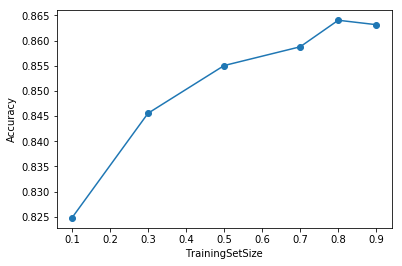

In [8]:
from matplotlib import pyplot
pyplot.plot(splitProportion,Accuracy,marker='o')
pyplot.ylabel('Accuracy')
pyplot.xlabel('TrainingSetSize')